In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import os.path as osp
import sys

import cv2
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import deepdish as dd
import numpy as np
from smplx import SMPLX
sys.path.insert(0, osp.join('..', 'main'))
sys.path.insert(0, osp.join('..', 'data'))
sys.path.insert(0, osp.join('..', 'data/LAIONSynth/'))
sys.path.insert(0, osp.join('..', 'common'))

from config import cfg
cfg.get_config_fromfile(config_path='../main/config/config_smpler_x_s_synth.py')

from utils.human_models import smpl_x
from torch.utils.data import Dataset

from LAIONSynth import LAIONSynth

/mnt/vol_b/miniconda3/envs/smplerx/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/vol_b/miniconda3/envs/smplerx/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [5]:
def plot_points_on_image(image, points, color=(0, 0, 255), radius=3, thickness=-1):
    """
    Plots a batch of 2D points on an image using OpenCV.

    Args:
        image (numpy.ndarray): The image to plot the points on.
        points (numpy.ndarray): A 2D array of shape (batch_size, 2) containing 
                                the (x, y) coordinates of the points.
        color (tuple, optional): The color of the points in BGR format. 
                                 Defaults to (0, 0, 255) (blue).
        radius (int, optional): The radius of the points. Defaults to 3.
        thickness (int, optional): The thickness of the point's circle. A value
                                   of -1 will fill the circle. Defaults to -1.
    """

    # Make a copy of the image so we don't modify the original
    image_copy = image.copy() 

    # Iterate through each point in the batch
    for x, y in points:
        center_coordinates = (int(x), int(y))  # Convert to integer coordinates
        cv2.circle(image_copy, center_coordinates, radius, color, thickness)

    return image_copy 

In [9]:
# images_path = '/mnt/vol_f/control-human-gen-v2/laion-faces/densepose_gen/'
# labels_path = '/mnt/vol_f/control-human-gen-v2/laion-faces/smplerx-pred-2/'
ds = LAIONSynth(None, data_split='train')
len(ds)

294537

In [ ]:
%%time
#dict_keys(['bbox', 'betas', 'body_pose', 'expression', 'focal', 'global_orient', 'jaw_pose', 
# 'left_hand_pose', 'leye_pose', 'princpt', 'reye_pose', 'right_hand_pose', 'transl'])

inputs, targets, meta_info = ds[21285]
img = (inputs['img'] * 255).byte().permute(1,2,0).numpy()
plt.figure(figsize=(7, 7))
plt.imshow(plot_points_on_image(img, targets['joint_img'][:, :2] / np.array([12, 16])  * np.array([384, 512])))
# plt.imshow(inputs['img'].permute(1,2,0))
# plt.imshow(img_orig / 255.)

CPU times: user 1.54 s, sys: 229 ms, total: 1.77 s
Wall time: 493 ms


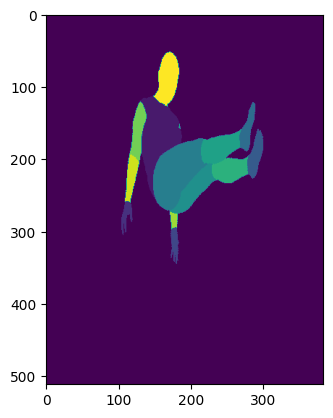

In [57]:
plt.imshow(densepose)

In [59]:
print(lhand_bbox, rhand_bbox, face_bbox, sep='\n')

[172.5        295.5        183.5        345.76688051]
[104.5 259.5 119.5 305.5]
[148.5  52.5 183.5 127.5]


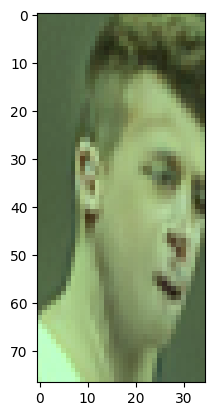

In [61]:
plt.imshow(img[50:127, 148:183])

In [393]:
joint_img[:, 2]

10.683614730834961

In [242]:
smplx_model = SMPLX('common/utils/human_model_files/smplx/SMPLX_NEUTRAL.npz', use_pca=False)

pose = torch.from_numpy(targets['smplx_pose'].reshape(-1, 3))
with torch.no_grad():
    output = smplx_model(
        betas=torch.from_numpy(targets['smplx_shape'])[None],
        global_orient= pose[0:1][None],
        body_pose= pose[1:22][None],
        left_hand_pose=pose[22:37][None],
        right_hand_pose=pose[37:52][None],
        jaw_pose=pose[52:53][None],
        leye_pose= torch.zeros(1, 1, 3),
        reye_pose= torch.zeros(1, 1, 3),
        expression=torch.zeros(1, 10),
        pose2rot=True,   
    )
    joints3d = output.joints[0] + torch.from_numpy(targets['trans'])
    joints2d= (joints3d[:, :2] / joints3d[:, 2:]) * torch.from_numpy(inputs['focal']) + torch.from_numpy(inputs['pp'])
    joints2d = joints2d.detach().cpu().numpy()

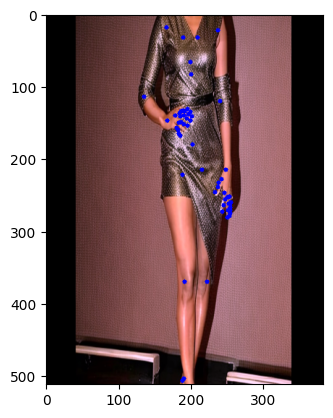

In [241]:
image = (inputs['img'].permute(1,2,0) * 255).byte().cpu().numpy()
plt.imshow(plot_points_on_image(image, joints2d))

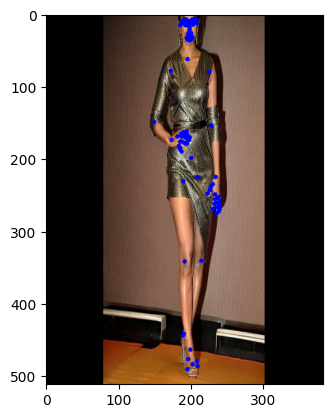

In [119]:
image = (inputs['img'].permute(1,2,0) * 255).byte().cpu().numpy()
joints2d = (targets['joint_img'][:, :2] ) / np.array([12, 16]) * np.array([384, 512])
plt.imshow(plot_points_on_image(image, joints2d))